# Libs Importing 

In [1]:
# !pip install jupyter-autotime
%load_ext autotime

import pandas as pd
import numpy as np
import re

from sklearn import feature_selection
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# import seaborn as sns
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# %matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

pd.options.plotting.backend = "plotly"
pd.options.display.max_columns = None

# Functions

In [2]:
random_state = 99
tp_over = 'smt'
var_target = 'Exited'

def df_shape(df):
    print('Linhas:', df.shape[0])
    print('Colunas:', df.shape[1])


def Limpeza_cols(instancia):
    instancia = re.sub(r"", "", instancia).replace('-','_')\
    .replace(':','').replace('+','').replace('<','').replace('>','')\
    .replace('#','').replace('$','').replace('&','').replace('*','').replace('á','a').replace('é','e').replace('í','i')\
    .replace('ó','o').replace('ú','u').replace('ã','a').replace('õ','o').replace('â','a').replace('ê','e')\
    .replace('ô','o').replace('û','u').replace('?','').replace('.','_').replace('/','_').replace('\\','').replace('ç','c')\
    .replace(' ','_').replace('º','o').replace('ª','a')
    return (instancia)


def df_shape(dataframe):
    print('Linhas:', dataframe.shape[0])
    print('Colunas:', dataframe.shape[1])


def FSelection(X_train, y_train, k, fs='m'):
  
    if fs == 'm':
        fs = feature_selection.mutual_info_classif
        # quanto maior melhor
        mir = fs(X_train, y_train)
        mir = pd.DataFrame(mir)

    elif fs == 'f':
        fs = feature_selection.f_classif
        # quanto menor melhor
        mir = fs(X_train, y_train)
        mir = pd.DataFrame(mir[0])

    mir.index = X_train.columns
    mir = mir.sort_values(0, ascending=False)

    mir_kbest = feature_selection.SelectKBest(fs, k=k).fit(X_train, y_train)
    mir_kbest_cols = X_train.columns[mir_kbest.get_support()]
    mir_kbest_cols = list(mir_kbest_cols.values)

    mir = mir.T[mir_kbest_cols].T.sort_values(0, ascending=False)

    fig = px.bar(mir, x=mir.index.values, y=mir[0])
    fig_show = fig.show()

    return mir.index.tolist(), fig_show


def FSelection_model(X_train, y_train, X_test, y_test, k, ml='mlp', random_state=random_state):

    roc_auc_values = []

    for feature in X_train.columns:

        if ml == 'rf':
            clf = RandomForestClassifier(random_state=random_state)
        elif ml == 'etree':
            clf = ExtraTreesClassifier(random_state=random_state)
        elif ml == 'lr':
            clf = LogisticRegression(random_state=random_state)
        elif ml == 'mlp':
            clf = MLPClassifier(max_iter = 500, random_state=random_state, solver='lbfgs')
        elif ml == 'xgb':
            clf = XGBClassifier(eval_metric='logloss', random_state=random_state)

        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict_proba(X_test[feature].to_frame())
        roc_auc_values.append(roc_auc_score(y_test, y_scored[:,1]))  # quanto maior melhor
        # accuracy_score(y_test, y_scored)

    roc_auc_values = pd.Series(roc_auc_values)
    roc_auc_values.index = X_train.columns
    roc_auc_values.sort_values(ascending=False, inplace=True)  # nao alterar esse ascending
    roc_auc_values = pd.DataFrame(roc_auc_values)

    roc_auc_values_cols = list(roc_auc_values.index.values)
    roc_auc_values_cols = roc_auc_values_cols[0:k]

    fig = roc_auc_values.loc[roc_auc_values_cols].plot.bar()
    fig_show = fig.show()

    return roc_auc_values, roc_auc_values_cols, fig_show


def corr_plot(method):
    corr = df_corr.corr(method=method)
    fig = px.imshow(corr)
    fig.update_layout(width=1000, height=1000)
    display(fig)


def metrics_binary(y_test, pred, pred_prob):
    accuracy = accuracy_score(y_test, pred)
    metrics = precision_recall_fscore_support(y_test, pred, average='binary')
    c_matrix = confusion_matrix(y_test, pred)
    auc = roc_auc_score(y_test, pred_prob[:,1])
    
    print('Acurácia:', accuracy)
    print('Precisão:', metrics[0])
    print('Sensibilidade (Recall):', metrics[1])
    print('F1-Score:', metrics[2])
    print('AUC:', auc)
    print('Matriz de confusão:\n', c_matrix)
    
    return accuracy, metrics[0], metrics[1], metrics[2], auc

def Diff_list(list1, list2):
    return list(set(list1) - set(list2)) + list(set(list2) - set(list1))

# Data Extract

In [3]:
df_full = pd.read_csv(r'base/data.csv', sep=',', encoding='utf-8')[:8000]
df_full.columns = [Limpeza_cols(i) for i in df_full.columns]
df_full.head(3)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1

# Data Info

In [4]:
df_full.describe()

RowNumber    CustomerId  CreditScore          Age       Tenure  \
count  8000.00000  8.000000e+03  8000.000000  8000.000000  8000.000000   
mean   4000.50000  1.569069e+07   650.179625    38.937875     5.012750   
std    2309.54541  7.157970e+04    96.844314    10.511224     2.884376   
min       1.00000  1.556570e+07   350.000000    18.000000     0.000000   
25%    2000.75000  1.562869e+07   583.000000    32.000000     3.000000   
50%    4000.50000  1.569035e+07   651.000000    37.000000     5.000000   
75%    6000.25000  1.575234e+07   717.000000    44.000000     7.000000   
max    8000.00000  1.581569e+07   850.000000    92.000000    10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count    8000.000000    8000.000000  8000.000000     8000.000000   
mean    76800.037193       1.528000     0.701625        0.512625   
std     62391.192584       0.583102     0.457574        0.499872   
min         0.000000       1.000000     0.000000        0.000000   
25%         0.000000       1.000000     0.000000        0.000000   
50%     97658.060000       1.000000     1.000000        1.000000   
75%    127827.332500       2.000000     1.000000        1.000000   
max    250898.090000       4.000000     1.000000        1.000000   

       EstimatedSalary       Exited  
count      8000.000000  8000.000000  
mean     100198.588701     0.205875  
std       57524.002768     0.404365  
min          11.580000     0.000000  
25%       51271.410000     0.000000  
50%      100272.165000     0.000000  
75%      149372.387500     0.000000  
max      199992.480000     1.000000

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        8000 non-null   int64  
 1   CustomerId       8000 non-null   int64  
 2   Surname          8000 non-null   object 
 3   CreditScore      8000 non-null   int64  
 4   Geography        8000 non-null   object 
 5   Gender           8000 non-null   object 
 6   Age              8000 non-null   int64  
 7   Tenure           8000 non-null   int64  
 8   Balance          8000 non-null   float64
 9   NumOfProducts    8000 non-null   int64  
 10  HasCrCard        8000 non-null   int64  
 11  IsActiveMember   8000 non-null   int64  
 12  EstimatedSalary  8000 non-null   float64
 13  Exited           8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 875.1+ KB


In [6]:
df_full['Exited'].value_counts(normalize=True)

0    0.794125
1    0.205875
Name: Exited, dtype: float64

In [7]:
df_shape(df_full)

Linhas: 8000
Colunas: 14


In [8]:
df_full.isnull().sum().sum()

0

In [9]:
df_full.duplicated().sum()

0

In [10]:
df_full.duplicated(subset=['CustomerId']).sum()

0

In [11]:
df_full['CustomerId'].nunique()

8000

# Data Cleaning / Transform

## Remove Cols

In [12]:
cols_df_full = df_full.columns.tolist()
cols_remove = ['RowNumber']

[cols_df_full.remove(i) for i in cols_remove]

df_full = df_full[cols_df_full]

## Vars conversion

In [13]:
lista_aux = ['CustomerId', 'HasCrCard', 'IsActiveMember']

for i in lista_aux:
    if i in df_full.columns.tolist():
        df_full[i] = df_full[i].astype(str)

In [14]:
df_full.set_index('CustomerId', inplace=True)

## Model Data Preparing

### Resample SKLearn (Oversampling)

### Separando previsores e target

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

def Xy(df_full=df_full, var_target=var_target):
    X = df_full.drop([var_target], axis=1)
    y = df_full[var_target]
    return X, y
    
def Split(X, y):
    X_train_nr, X_test_nr, y_train_nr, y_test_nr = train_test_split(X, y, test_size=0.1, random_state=random_state)
    print('Qtdd de treino:', len(X_train_nr))
    print('Qtdd de teste:', len(X_test_nr))
    return X_train_nr, X_test_nr, y_train_nr, y_test_nr
    
def Scaler(scaler, X):
    numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
    categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

    if scaler == 'minmax':
        scaler = MinMaxScaler()
        scaler.fit(X[numerical_cols])
    if scaler == 'standard':
        scaler = StandardScaler()
        scaler.fit(X[numerical_cols])
    return scaler, numerical_cols, categorical_cols
    
def Over(tp_over, scaler, var_target=var_target, df_full=df_full):
    
    if tp_over == 'skl':
        
        print('Balanceamento: Resample')

        df_resample = df_full.loc[df_full[var_target]==0]
        df_resample_c = df_full.loc[df_full[var_target]==1]
        df_resample_concat = resample(df_resample_c, replace=True, n_samples=len(df_resample)-len(df_resample_c), random_state=random_state)
        df_full = pd.concat([df_full, df_resample_concat])

        print(df_full[var_target].value_counts())
        
        X, y = Xy(df_full)
        X_train, X_test, y_train, y_test = Split(X, y)
        scaler, numerical_cols, categorical_cols = Scaler(scaler, X)
        
        X_train_num = X_train[numerical_cols].copy()
        X_test_num = X_test[numerical_cols].copy()
        X_train_num = scaler.transform(X_train_num)
        X_test_num = scaler.transform(X_test_num)
        X_train_num = pd.DataFrame(X_train_num)
        X_test_num = pd.DataFrame(X_test_num)
        X_train_num.columns = numerical_cols
        X_test_num.columns = numerical_cols
        X_train_num.set_index(X_train.index, inplace=True)
        X_test_num.set_index(X_test.index, inplace=True)
        
        enc = TargetEncoder()
        enc.fit(X[categorical_cols], y)
        X_train_cat = X_train[categorical_cols].copy()
        X_test_cat = X_test[categorical_cols].copy()
        X_train_cat = enc.transform(X_train_cat)
        X_test_cat = enc.transform(X_test_cat)

        X_train_cat.reset_index(drop=True, inplace=True)
        X_train_num.reset_index(drop=True, inplace=True)
        X_test_cat.reset_index(drop=True, inplace=True)
        X_test_num.reset_index(drop=True, inplace=True)
        X_train_cat.reset_index(inplace=True)
        X_train_num.reset_index(inplace=True)
        X_test_cat.reset_index(inplace=True)
        X_test_num.reset_index(inplace=True)
        X_train_nr = X_train_cat.merge(X_train_num, on='index')
        X_test_nr = X_test_cat.merge(X_test_num, on='index')
        X_train_nr.drop('index', axis=1, inplace=True)
        X_test_nr.drop('index', axis=1, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)
        
        return X_train_nr, X_test_nr, y_train, y_test, X, y
    
    if tp_over == 'smt':
        
        print('Balanceamento: SMOTE')
        
        X, y = Xy()

        scaler, numerical_cols, categorical_cols = Scaler(scaler, X)

        X_num = X[numerical_cols].copy()
        X_num = scaler.transform(X_num)
        X_num = pd.DataFrame(X_num)
        X_num.columns = numerical_cols
        X_num.set_index(X.index, inplace=True)

        enc = TargetEncoder()
        enc.fit(X[categorical_cols], y)

        X_cat = X[categorical_cols].copy()
        X_cat = enc.transform(X_cat)

        X_nr = X_cat.merge(X_num, on=X_cat.index)
        X_nr.set_index('key_0', inplace=True)
        X_nr.index.rename('cod_cliente', inplace=True)

        y_nr = y.copy()

        oversample = SMOTE(random_state=random_state)
        X_nr, y_nr = oversample.fit_resample(X_nr, y_nr)


        X_train_nr, X_test_nr, y_train_nr, y_test_nr = Split(X_nr, y_nr)
        print(y_nr.value_counts())
        
        return X_train_nr, X_test_nr, y_train_nr, y_test_nr

In [16]:
X, y = Xy()

if tp_over == 'smt':
    X_train_nr, X_test_nr, y_train_nr, y_test_nr = Over(tp_over='smt', scaler='standard')  # smote
else:
    X_train_nr, X_test_nr, y_train_nr, y_test_nr, X, y = Over(tp_over='skl', scaler='minmax')  # resample
    

X_nr = X_train_nr.copy(); y_nr = y_train_nr.copy()

Balanceamento: SMOTE
Qtdd de treino: 11435
Qtdd de teste: 1271
1    6353
0    6353
Name: Exited, dtype: int64


### Pré-processamento FS / MS

## Model Selection

In [17]:
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import roc_auc_score, accuracy_score

In [18]:
class ModeloAuxiliar(object):
    def __init__(self, clf, seed=123, params=None):
        if params:
            params['random_state'] = seed
            self.clf = clf(**params)
        else:
            self.clf = clf()
    def predict(self, x):
        return self.clf.predict(x)
    # Para treinar o modelo
    def fit(self,x,y):
        return self.clf.fit(x,y)
    # A importancia dos recursos para determinado modelo preditivo
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    # Pega o R quadrado
    def score(self,x,y):
        return self.clf.score(x,y)

In [19]:
modelos = [
           {'nome': 'LogisticRegression', 'modelo': LogisticRegression},
           {'nome': 'ExtraTreesClassifier', 'modelo': ExtraTreesClassifier},
           {'nome': 'GradientBoostingClassifier', 'modelo': GradientBoostingClassifier}, 
           {'nome': 'AdaBoostClassifier', 'modelo': AdaBoostClassifier},
           {'nome': 'SVC', 'modelo': SVC},
           {'nome': 'KNeighborsClassifier', 'modelo': KNeighborsClassifier},
           {'nome': 'GaussianNB', 'modelo': GaussianNB},
           {'nome': 'Perceptron', 'modelo': Perceptron},
           {'nome': 'LinearSVC', 'modelo': LinearSVC},
           {'nome': 'SGDClassifier', 'modelo': SGDClassifier},
           {'nome': 'DecisionTreeClassifier', 'modelo': DecisionTreeClassifier},
           {'nome': 'RandomForestClassifier', 'modelo': RandomForestClassifier},
           {'nome': 'MLPClassifier', 'modelo': MLPClassifier},
           {'nome': 'XGBoostClassifier', 'modelo': XGBClassifier}
          ]

In [20]:
resultados = []
for model in modelos:
    x = ModeloAuxiliar(clf=model['modelo'])  
    x.fit(X_train_nr, y_train_nr) 
    x_pred = x.predict(X_test_nr)
    acuracidade = round(x.score(X_test_nr, y_test_nr)*100,2) 
    resultados.append({'nome': model['nome'], 'score': acuracidade, 'pred': x_pred })
models_resultados = pd.DataFrame(resultados)

models_resultados.sort_values('score', ascending=False)

[17:26:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


nome  score  \
1         ExtraTreesClassifier  93.39   
11      RandomForestClassifier  92.05   
13           XGBoostClassifier  92.05   
2   GradientBoostingClassifier  91.50   
3           AdaBoostClassifier  90.01   
10      DecisionTreeClassifier  88.28   
5         KNeighborsClassifier  85.52   
12               MLPClassifier  84.97   
4                          SVC  82.45   
6                   GaussianNB  81.75   
8                    LinearSVC  78.99   
0           LogisticRegression  78.91   
9                SGDClassifier  77.73   
7                   Perceptron  69.08   

                                                 pred  
1   [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...  
11  [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...  
13  [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...  
2   [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...  
3   [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...  
10  [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...  
5   [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...  
12  [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...  
4   [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, ...  
6   [1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, ...  
8   [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...  
0   [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...  
9   [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...  
7   [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...

## Feature Selection

### Correlation

In [21]:
X_nr.join(y_nr).corr().iloc[:,-1:].sort_values('Exited')

Exited
NumOfProducts   -0.049486
CreditScore     -0.026982
Tenure          -0.011240
HasCrCard       -0.002648
EstimatedSalary  0.017662
Gender           0.144302
Balance          0.148937
Geography        0.214406
IsActiveMember   0.218954
Age              0.363468
Surname          0.451850
Exited           1.000000

In [22]:
X_nr.join(y_nr).corr().iloc[:,-1:].sort_values('Exited', ascending=False).index.tolist()[1:]

['Surname',
 'Age',
 'IsActiveMember',
 'Geography',
 'Balance',
 'Gender',
 'EstimatedSalary',
 'HasCrCard',
 'Tenure',
 'CreditScore',
 'NumOfProducts']

### Univariate Selection

#### Mutual / F-test

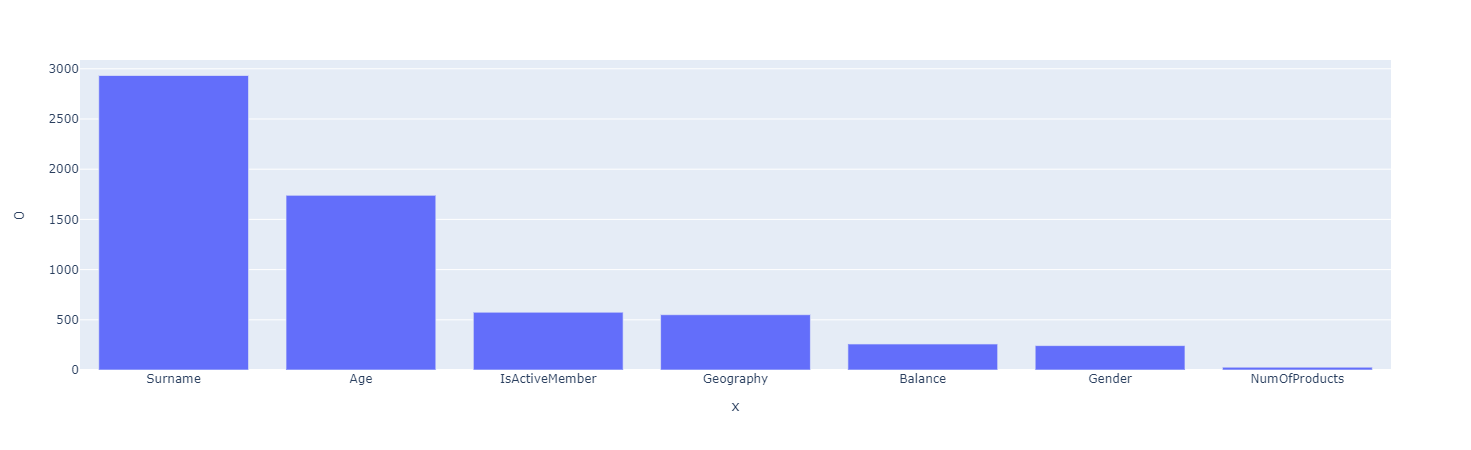

In [23]:
cols, _ = FSelection(X_train_nr, y_train_nr, 7, 'f')

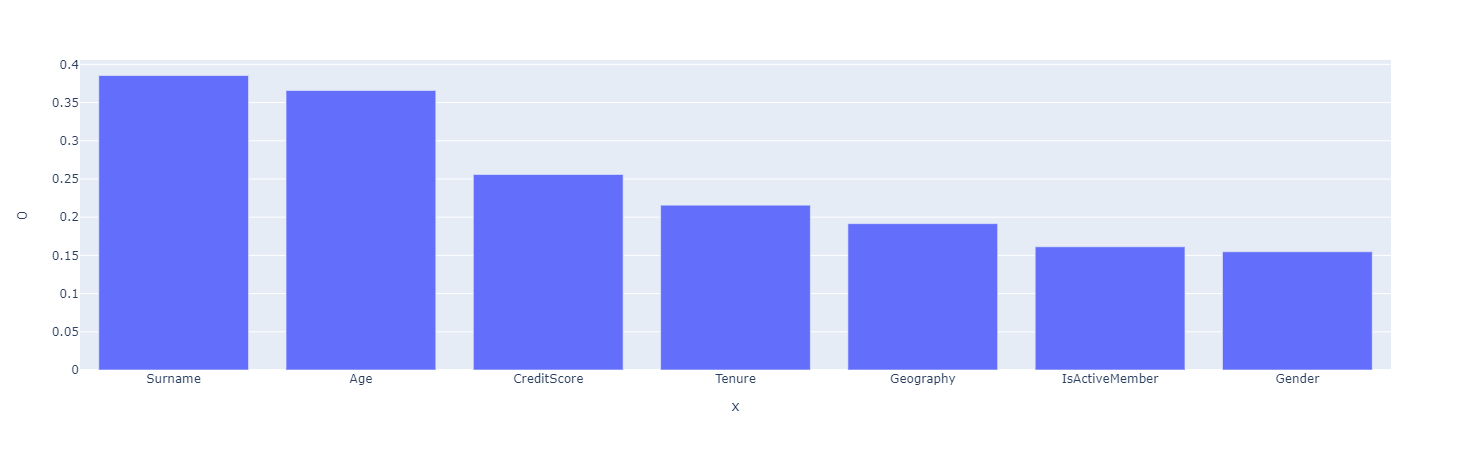

In [24]:
cols, _ = FSelection(X_train_nr, y_train_nr, 7, 'm')

### Recursive Feature Elimination (RFE)

In [25]:
n_fix = X_train_nr.columns.shape[0] + 1 
n = n_fix - 7
model = GradientBoostingClassifier(random_state=random_state)

rfe = RFE(model, n)
model = rfe.fit(X_train_nr, y_train_nr)

selected_vars = model.ranking_.tolist()
selected_vars.sort()
cols = X_train_nr.iloc[:,selected_vars].columns.tolist()
cols = list(dict.fromkeys(cols))
cols

['Geography',
 'Gender',
 'HasCrCard',
 'IsActiveMember',
 'CreditScore',
 'Age',
 'Tenure']

### Model (AUC)

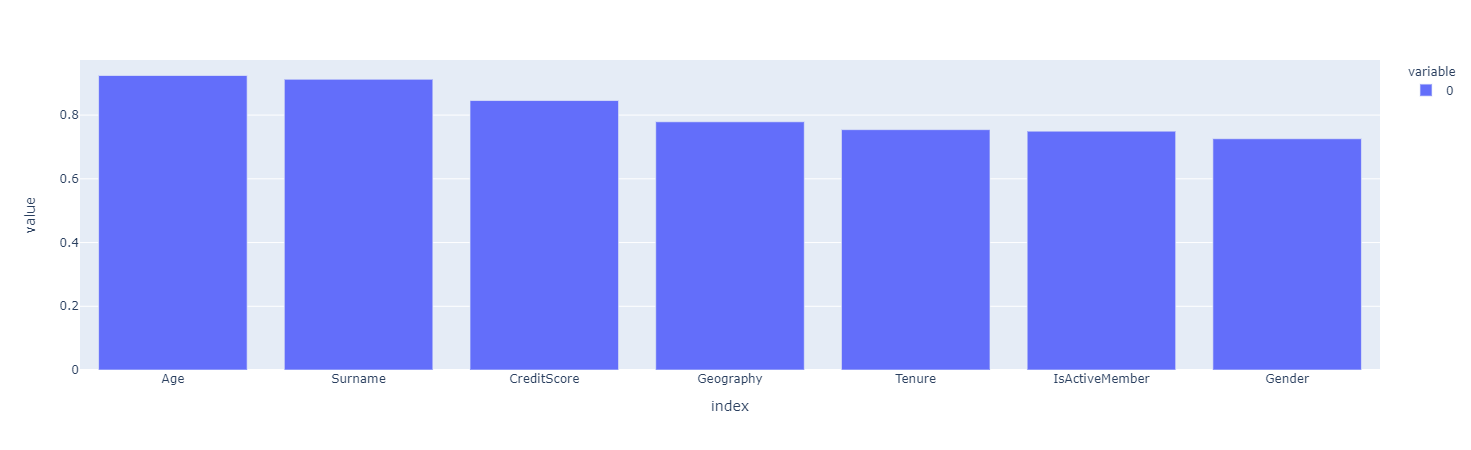

In [26]:
df_top_cols, cols, _ = FSelection_model(X_train_nr, y_train_nr, X_test_nr, y_test_nr, 7, 'rf')

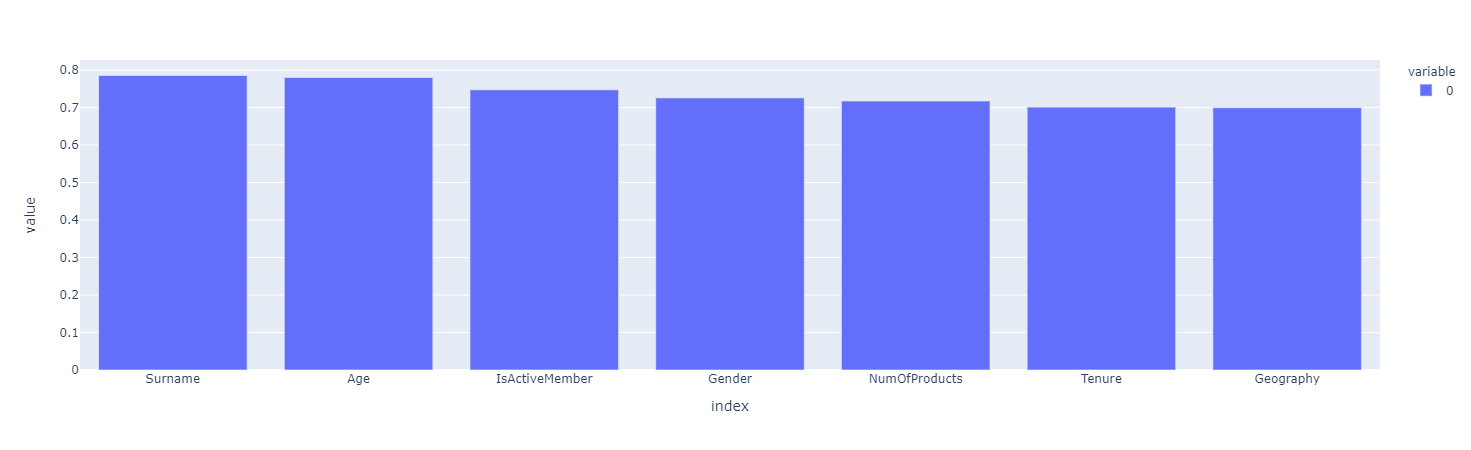

In [27]:
df_top_cols, cols, _ = FSelection_model(X_train_nr, y_train_nr, X_test_nr, y_test_nr, 7, 'mlp')

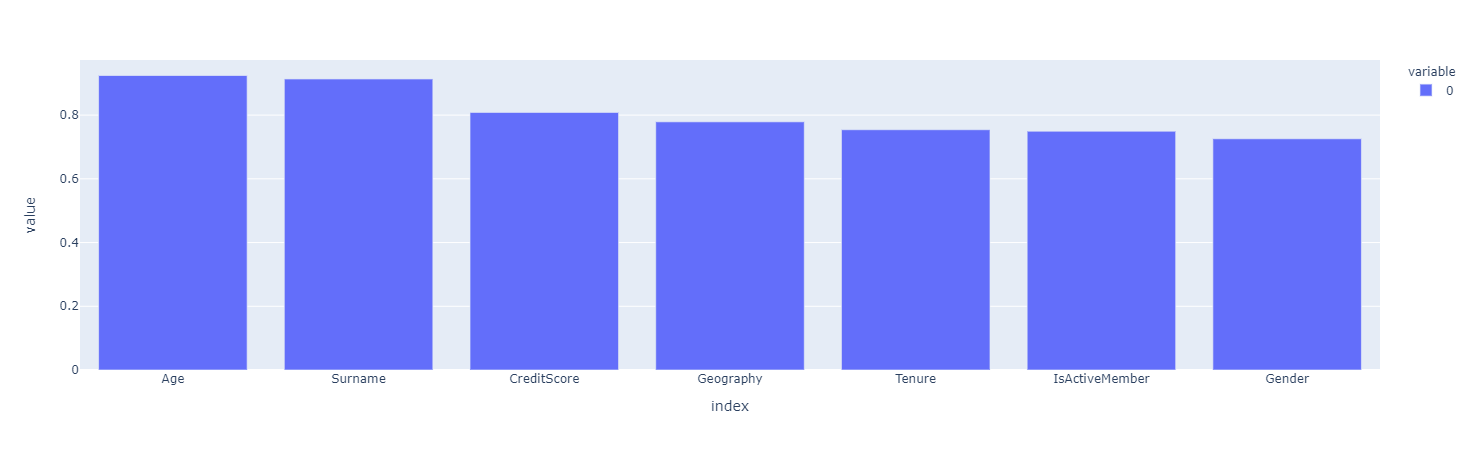

In [28]:
df_top_cols, cols, _ = FSelection_model(X_train_nr, y_train_nr, X_test_nr, y_test_nr, 7, 'xgb')

### Selected Cols

In [29]:
# # Para test de feats manuais
# cols = ['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
#        'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
#        'EstimatedSalary', 'Exited']

# if 'Exited' in cols:
#     cols.remove('Exited')

In [30]:
print(len(cols), 'cols')
print(cols)

7 cols
['Age', 'Surname', 'CreditScore', 'Geography', 'Tenure', 'IsActiveMember', 'Gender']


In [31]:
X = X[cols]

## Correlation

In [32]:
df_corr = X_train_nr[cols].copy()
df_corr['Exited'] = y_train_nr

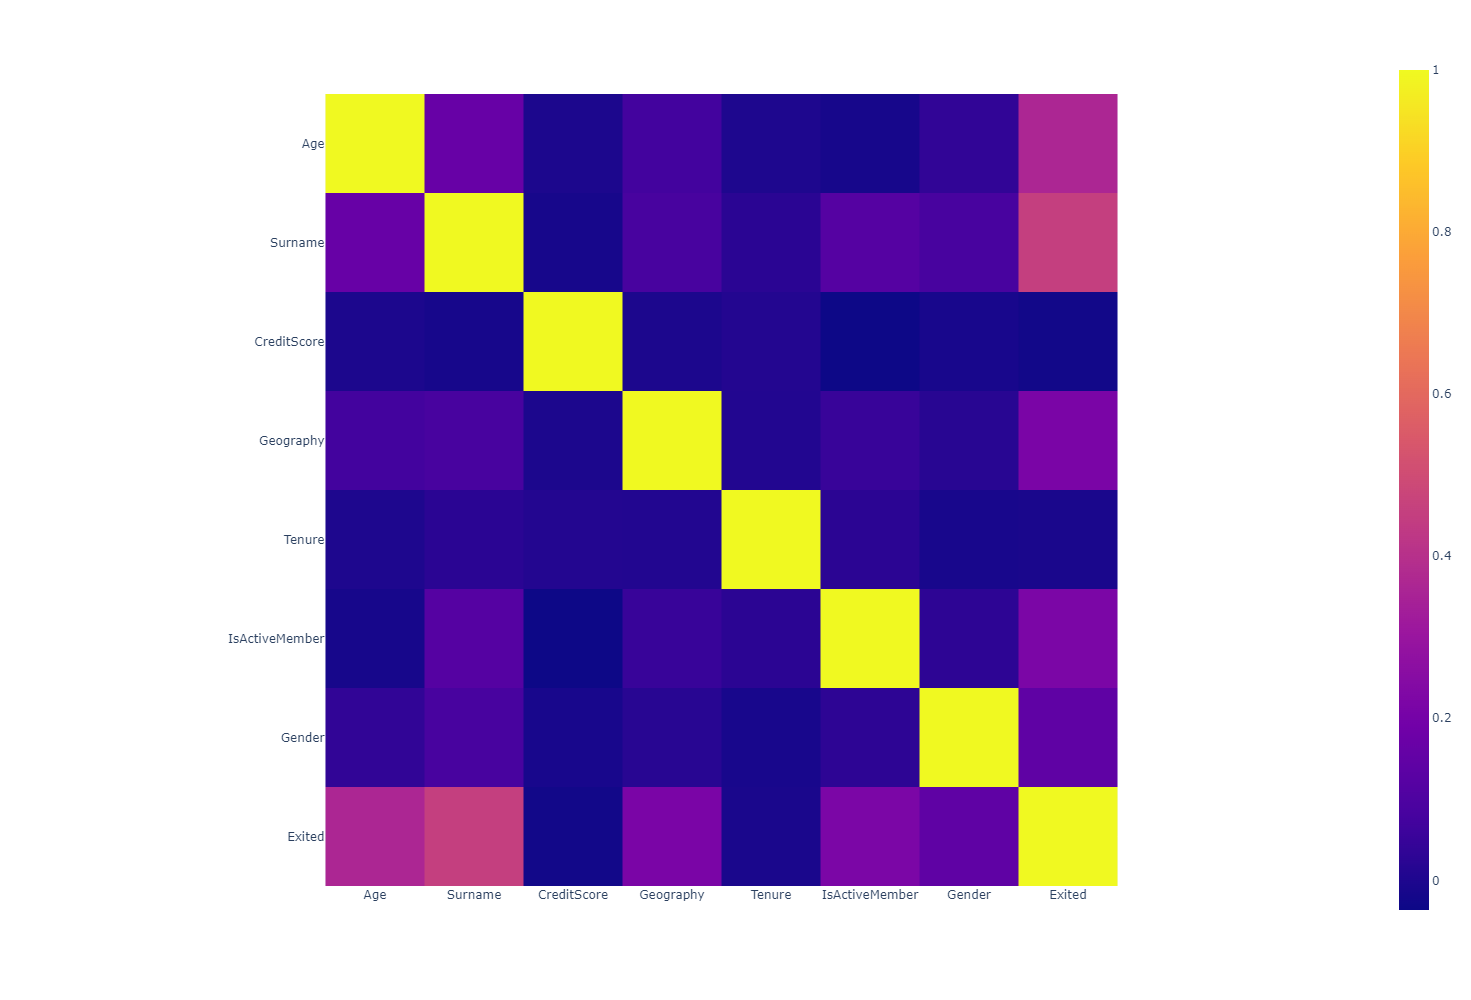

In [33]:
corr_plot('pearson')

In [34]:
# corr_plot('spearman')

In [35]:
# corr_plot('kendall')

## Skewness

In [36]:
X_train_nr.skew().sort_values()

Balance           -0.350741
IsActiveMember    -0.192775
CreditScore       -0.060768
EstimatedSalary   -0.015959
Tenure             0.017253
Gender             0.020381
Age                0.559895
Surname            0.642124
Geography          0.824034
HasCrCard          0.884934
NumOfProducts      1.243895
dtype: float64

# Modeling - ML

In [37]:
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols
X = X[my_cols].copy()
# X_test = X_test[my_cols].copy()

In [38]:
# Pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as pipesmote
from imblearn.pipeline import make_pipeline

# Pré-processamento
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn import preprocessing
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

# GridSearch/CV
from sklearn.model_selection import KFold, cross_validate, GridSearchCV

# Métricas
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [39]:
numerical_transformer = StandardScaler()
# numerical_transformer = MinMaxScaler()

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
#       ('ordinalEnc', OrdinalEncoder())
#        ('targetEnc', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

## Logistic Regression

In [40]:
model = LogisticRegression(random_state=random_state)
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    ml_name=2
    pipe = pipesmote([
        ('preprocessor', preprocessor),
        ('sampling', oversampling),
        ('model', model)
    ])

else:
    ml_name=1
    pipe = make_pipeline(
           preprocessor,
           model)

param_gs = {
    'model__penalty': ('l2','elasticnet'),
    'model__solver': ('lbfgs','saga','newton-cg'),
    'model__max_iter': (100,500,1000)
}

kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
lr_gs = GridSearchCV(pipe, param_gs, cv=kfold)
lr_gs.fit(X, y)
# lr_pred_gs = lr_gs.predict(X_test_nr)
# lr_pred_prob_gs = lr_gs.predict_proba(X_test_nr)


# metrics_binary(y_test_nr, lr_pred_gs, lr_pred_prob_gs)

lr_gs.best_params_

{'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}

In [41]:
model = LogisticRegression(max_iter=100, penalty='l2', solver='lbfgs', random_state=random_state)
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    ml_name=2
    pipe = make_pipeline(
           preprocessor,
           oversampling,
           model)
else:
    ml_name=1
    pipe = make_pipeline(
           preprocessor,
           model)


lr_model = pipe.fit(X, y)

## SVC (Linear)

In [42]:
# model = CalibratedClassifierCV(LinearSVC(random_state=random_state))
# oversampling = SMOTE(random_state=random_state)

# if tp_over == 'smt':
#     ml_name=2
#     pipe = pipesmote([
#         ('preprocessor', preprocessor),
#         ('sampling', oversampling),
#         ('model', model)
#     ])

# else:
#     ml_name=1
#     pipe = make_pipeline(
#            preprocessor,
#            model)

# param_gs = {
#     'model__loss': ('hinge','squared_hinge'),
#     'model__max_iter': (1000,1500,2000)
# }

# kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
# lsvc_gs = GridSearchCV(pipe, param_gs, cv=kfold)
# lsvc_gs.fit(X, y)
# # lsvc_pred_gs = lsvc_gs.predict(X_test)
# # lsvc_pred_prob_gs = lsvc_gs.predict_proba(X_test)


# # metrics_binary(y_test, lsvc_pred_gs, lsvc_pred_prob_gs)

# lsvc_gs.best_params_

In [43]:
model = CalibratedClassifierCV(LinearSVC(random_state=random_state))
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    pipe = make_pipeline(
           preprocessor,
           oversampling,
           model)
else:
    pipe = make_pipeline(
           preprocessor,
           model)

lsvc_model = pipe.fit(X, y)

## ExtraTrees

In [44]:
# model = ExtraTreesClassifier(random_state=random_state)
# oversampling = SMOTE(random_state=random_state)

# if tp_over == 'smt':
#     ml_name=2
#     pipe = pipesmote([
#         ('preprocessor', preprocessor),
#         ('sampling', oversampling),
#         ('model', model)
#     ])

# else:
#     ml_name=1
#     pipe = make_pipeline(
#            preprocessor,
#            model)

# param_gs = {
#     'model__n_estimators': (10,100,200),
#     'model__max_depth': (None,2,4),
#     'model__min_samples_split': (1,3),
#     'model__min_samples_leaf': (1,3),
#     'model__ccp_alpha': (0.0,0.1)
# }

# kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
# etree_gs = GridSearchCV(pipe, param_gs, cv=kfold)
# etree_gs.fit(X, y)
# # etree_pred_gs = etree_gs.predict(X_test)
# # etree_pred_prob_gs = etree_gs.predict_proba(X_test)

# # metrics_binary(y_test, etree_pred_gs, etree_pred_prob_gs)

# etree_gs.best_params_

In [45]:
# model = ExtraTreesClassifier(random_state=random_state)
model = ExtraTreesClassifier(ccp_alpha=0.0, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=random_state)
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    pipe = make_pipeline(
           preprocessor,
           oversampling,
           model)
else:
    pipe = make_pipeline(
           preprocessor,
           model)
etree_model = pipe.fit(X, y)

## GradientBoosting

In [46]:
# model = GradientBoostingClassifier(random_state=random_state)
# oversampling = SMOTE(random_state=random_state)

# if tp_over == 'smt':
#     ml_name=2
#     pipe = pipesmote([
#         ('preprocessor', preprocessor),
#         ('sampling', oversampling),
#         ('model', model)
#     ])

# else:
#     ml_name=1
#     pipe = make_pipeline(
#            preprocessor,
#            model)

# param_gs = {
#     'model__loss': ('deviance','exponential'),
#     'model__learning_rate': (0.05,0.1,0.15),
#     'model__min_samples_split': (1,2,3),
#     'model__min_samples_leaf': (1,2,3),
#     'model__n_estimators': (50,100,200)
# }

# kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
# gdboost_gs = GridSearchCV(pipe, param_gs, cv=kfold)
# gdboost_gs.fit(X, y)
# # gdboost_pred_gs = gdboost_gs.predict(X_test)
# # gdboost_pred_prob_gs = gdboost_gs.predict_proba(X_test)


# # metrics_binary(y_test, gdboost_pred_gs, gdboost_pred_prob_gs)

# gdboost_gs.best_params_

In [47]:
# model = GradientBoostingClassifier(random_state=random_state)
model = GradientBoostingClassifier(learning_rate=0.15, loss='deviance', min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=random_state)
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    pipe = make_pipeline(
           preprocessor,
           oversampling,
           model)
else:
    pipe = make_pipeline(
           preprocessor,
           model)

gdboost_model = pipe.fit(X, y)

## RandomForest

In [48]:
# model = RandomForestClassifier(random_state=random_state)
# oversampling = SMOTE(random_state=random_state)

# if tp_over == 'smt':
#     ml_name=2
#     pipe = pipesmote([
#         ('preprocessor', preprocessor),
#         ('sampling', oversampling),
#         ('model', model)
#     ])

# else:
#     ml_name=1
#     pipe = make_pipeline(
#            preprocessor,
#            model)

# param_gs = {
#     'model__criterion': ('gini','entropy'),
#     'model__ccp_alpha': (0.0,0.1),
#     'model__min_samples_split': (1,2,3),
#     'model__min_samples_leaf': (1,2,3),
#     'model__n_estimators': (50,100,200)
# }

# kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
# rf_gs = GridSearchCV(pipe, param_gs, cv=kfold)
# rf_gs.fit(X, y)
# # rf_pred_gs = rf_gs.predict(X_test)
# # rf_pred_prob_gs = rf_gs.predict_proba(X_test)


# # metrics_binary(y_test, rf_pred_gs, rf_pred_prob_gs)

# rf_gs.best_params_

In [49]:
# model = RandomForestClassifier(random_state=random_state)
model = RandomForestClassifier(ccp_alpha=0.0, criterion='entropy', min_samples_leaf=1, min_samples_split=3, n_estimators=200, random_state=random_state)
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    pipe = make_pipeline(
           preprocessor,
           oversampling,
           model)
else:
    pipe = make_pipeline(
           preprocessor,
           model)

rf_model = pipe.fit(X, y)

## MLP (Neural Network)

In [50]:
# mlp = MLPClassifier(random_state=random_state)

# pipe = Pipeline(steps=[#('preprocessor', preprocessor),
#                       ('model', mlp)
#                      ])

# param_gs = {
#     'model__hidden_layer_sizes': ([18,36],[50,100],18,50,100,[18,18,18]),
#     'model__activation': ('relu','logistic'),
#     'model__max_iter': (100,500,1000,1500)
# }

# kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
# mlp_gs = GridSearchCV(pipe, param_gs, cv=kfold)
# mlp_gs.fit(X_train, y_train)
# mlp_pred_gs = mlp_gs.predict(X_test)
# mlp_pred_prob_gs = mlp_gs.predict_proba(X_test)


# metrics_binary(y_test, mlp_pred_gs, mlp_pred_prob_gs)

# mlp_gs.best_params_

In [51]:
# model = MLPClassifier(random_state=random_state)
# oversampling = SMOTE(random_state=random_state)

# if tp_over == 'smt':
#     ml_name=2
#     pipe = pipesmote([
#         ('preprocessor', preprocessor),
#         ('sampling', oversampling),
#         ('model', model)
#     ])

# else:
#     ml_name=1
#     pipe = make_pipeline(
#            preprocessor,
#            model)

# param_gs = {
#     'model__hidden_layer_sizes': ([240,240],[50,100],[240,100]),
#     'model__activation': (['relu']),
#     'model__max_iter': ([500]),
#     'model__learning_rate_init': (0.0001,0.001,0.005)
# }

# kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
# mlp_gs = GridSearchCV(pipe, param_gs, cv=kfold)
# mlp_gs.fit(X, y)
# # mlp_pred_gs = mlp_gs.predict(X_test)
# # mlp_pred_prob_gs = mlp_gs.predict_proba(X_test)


# # metrics_binary(y_test, mlp_pred_gs, mlp_pred_prob_gs)

# mlp_gs.best_params_

In [52]:
# model = MLPClassifier(max_iter=500, solver='lbfgs', random_state = random_state)
model = MLPClassifier(max_iter=500, hidden_layer_sizes=[240, 240, 240], learning_rate_init=0.001, solver='lbfgs', random_state = random_state)
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    pipe = make_pipeline(
           preprocessor,
           oversampling,
           model)
else:
    pipe = make_pipeline(
           preprocessor,
           model)

mlp_model = pipe.fit(X, y)

## XGBoost

In [53]:
# model = XGBClassifier(random_state=random_state)
# oversampling = SMOTE(random_state=random_state)

# if tp_over == 'smt':
#     ml_name=2
#     pipe = pipesmote([
#         ('preprocessor', preprocessor),
#         ('sampling', oversampling),
#         ('model', model)
#     ])

# else:
#     ml_name=1
#     pipe = make_pipeline(
#            preprocessor,
#            model)

# param_gs = {
#     'model__learning_rate': (0.1,0.2,0.3),
# #     'model__max_depth ': (4,6,8),
#     'model__reg_lambda': (0,1),
#     'model__reg_alpha': (0,1),
# }

# kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
# xgb_gs = GridSearchCV(pipe, param_gs, cv=kfold)
# xgb_gs.fit(X, y)
# # xgb_pred_gs = xgb_gs.predict(X_test)
# # xgb_pred_prob_gs = xgb_gs.predict_proba(X_test)


# # metrics_binary(y_test, xgb_pred_gs, xgb_pred_prob_gs)

# xgb_gs.best_params_

In [54]:
# model = XGBClassifier(random_state=random_state)
model = XGBClassifier(learning_rate=0.3, reg_alpha=0, reg_lambda=1, random_state=random_state)
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    pipe = make_pipeline(
           preprocessor,
           oversampling,
           model)
else:
    pipe = make_pipeline(
           preprocessor,
           model)

xgb_model = pipe.fit(X, y)

[17:33:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Ensembling - Voting

In [55]:
# model_a = MLPClassifier(max_iter=500, hidden_layer_sizes=[240, 240, 240], learning_rate_init=0.001, solver='lbfgs', random_state = random_state)
# model_b = GradientBoostingClassifier(learning_rate=0.15, loss='deviance', min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=random_state)
# model_c = XGBClassifier(learning_rate=0.3, reg_alpha=0, reg_lambda=1, random_state=random_state)
model_a = MLPClassifier(max_iter=500, solver='lbfgs', random_state = random_state)
model_b = GradientBoostingClassifier(random_state=random_state)
model_c = XGBClassifier(random_state=random_state)
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    pipe_model_a = make_pipeline(
           preprocessor,
           oversampling,
           model_a)
    
    pipe_model_b = make_pipeline(
           preprocessor,
           oversampling,
           model_b)

    pipe_model_c = make_pipeline(
           preprocessor,
           oversampling,
           model_c)
else:
    pipe_model_a = make_pipeline(
           preprocessor,
           model_a)
    
    pipe_model_b = make_pipeline(
           preprocessor,
           model_b)

    pipe_model_c = make_pipeline(
           preprocessor,
           model_c)

estimators = [
                ('pipe_a',pipe_model_a),
                ('pipe_b',pipe_model_b),
                ('pipe_c',pipe_model_c),
             ]

from sklearn.ensemble import VotingClassifier
ensemble_vc = VotingClassifier(estimators=estimators, voting='soft').fit(X, y)

[17:33:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Ensembling - Stacking

In [56]:
# model_a = MLPClassifier(max_iter=500, hidden_layer_sizes=[240, 240, 240], learning_rate_init=0.001, solver='lbfgs', random_state = random_state)
# model_b = GradientBoostingClassifier(learning_rate=0.15, loss='deviance', min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=random_state)
# model_c = XGBClassifier(learning_rate=0.3, reg_alpha=0, reg_lambda=1, random_state=random_state)
model_a = MLPClassifier(max_iter=500, solver='lbfgs', random_state = random_state)
model_b = GradientBoostingClassifier(random_state=random_state)
model_c = XGBClassifier(random_state=random_state)
oversampling = SMOTE(random_state=random_state)

if tp_over == 'smt':
    pipe_model_a = make_pipeline(
           preprocessor,
           oversampling,
           model_a)
    
    pipe_model_b = make_pipeline(
           preprocessor,
           oversampling,
           model_b)

    pipe_model_c = make_pipeline(
           preprocessor,
           oversampling,
           model_c)
else:
    pipe_model_a = make_pipeline(
           preprocessor,
           model_a)
    
    pipe_model_b = make_pipeline(
           preprocessor,
           model_b)

    pipe_model_c = make_pipeline(
           preprocessor,
           model_c)

estimators = [
                ('pipe_a',pipe_model_a),
                ('pipe_b',pipe_model_b),
                ('pipe_c',pipe_model_c),
             ]

from sklearn.ensemble import StackingClassifier
ensemble_sc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X, y)

[17:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

# Test

In [84]:
df_valid = pd.read_csv(r'base/test.csv', sep=',', encoding='utf-8')
df_full.columns = [Limpeza_cols(i) for i in df_full.columns]
df_valid.head(3)

RowNumber  CustomerId    Surname  CreditScore Geography Gender  Age  \
0       8001    15629002   Hamilton          747   Germany   Male   36   
1       8002    15798053  Nnachetam          707     Spain   Male   32   
2       8003    15753895       Blue          590     Spain   Male   37   

   Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       8  102603.3              2          1               1   
1       9       0.0              2          1               0   
2       1       0.0              2          0               0   

   EstimatedSalary  Exited  
0        180693.61       0  
1        126475.79       0  
2        133535.99       0

In [85]:
df_valid.shape

(2000, 14)

In [86]:
sol_temp_aux = Diff_list(df_full.columns.tolist(), df_valid.columns.tolist())

for i in sol_temp_aux:
    if i not in df_valid.columns.tolist():
        df_valid[i] = 0

In [87]:
df_valid['Exited'].value_counts()

0    1610
1     390
Name: Exited, dtype: int64

In [88]:
df_valid['Exited'].value_counts(normalize=True)

0    0.805
1    0.195
Name: Exited, dtype: float64

In [89]:
df_shape(df_valid)

Linhas: 2000
Colunas: 14


In [90]:
df_valid.isnull().sum().sum()

0

In [91]:
lista_aux = ['CustomerId', 'HasCrCard', 'IsActiveMember']

for i in lista_aux:
    if i in df_valid.columns.tolist():
        df_valid[i] = df_valid[i].astype(str)

In [92]:
df_valid.set_index('CustomerId', inplace=True)

In [93]:
cols_df_valid = df_valid.columns.tolist()
cols_remove = ['RowNumber']

[cols_df_valid.remove(i) for i in cols_remove]

df_valid = df_valid[cols_df_valid]

In [94]:
df_valid

Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
CustomerId                                                                     
15629002     Hamilton          747   Germany    Male   36       8  102603.30   
15798053    Nnachetam          707     Spain    Male   32       9       0.00   
15753895         Blue          590     Spain    Male   37       1       0.00   
15595426      Madukwe          603     Spain    Male   57       6  105000.85   
15645815        Mills          615    France    Male   45       5       0.00   
...               ...          ...       ...     ...  ...     ...        ...   
15606229     Obijiaku          771    France    Male   39       5       0.00   
15569892    Johnstone          516    France    Male   35      10   57369.61   
15584532          Liu          709    France  Female   36       7       0.00   
15682355    Sabbatini          772   Germany    Male   42       3   75075.31   
15628319       Walker          792    France  Female   28       4  130142.79   

            NumOfProducts HasCrCard IsActiveMember  EstimatedSalary  Exited  
CustomerId                                                                   
15629002                2         1              1        180693.61       0  
15798053                2         1              0        126475.79       0  
15753895                2         0              0        133535.99       0  
15595426                2         1              1         87412.24       1  
15645815                2         1              1        164886.64       0  
...                   ...       ...            ...              ...     ...  
15606229                2         1              0         96270.64       0  
15569892                1         1              1        101699.77       0  
15584532                1         0              1         42085.58       1  
15682355                2         1              0         92888.52       1  
15628319                1         1              0         38190.78       0  

[2000 rows x 12 columns]

In [95]:
X_valid = df_valid.drop(['Exited'], axis=1)
y_valid = df_valid['Exited']

In [99]:
# categorical_cols = [cname for cname in X_valid.columns if X_valid[cname].dtype == "object"]
# numerical_cols = [cname for cname in X_valid.columns if X_valid[cname].dtype in ['int64', 'float64']]

# my_cols = categorical_cols + numerical_cols
# X_valid = X_valid[my_cols].copy()

In [97]:
lr_pred = lr_model.predict(X_valid)
lr_pred_prob = lr_model.predict_proba(X_valid)
# lr_pred_prob = (lr_model.predict_proba(X_test_nr) >=0.27).astype(int)

print( type(lr_model[ml_name]).__name__ ) 
# acc, prec, rec, f1, auc = metrics_binary(y_test_nr, lr_pred_prob[:,1], lr_pred_prob)
acc, prec, rec, f1, auc = metrics_binary(y_valid, lr_pred, lr_pred_prob)
lista_metrics=[]
lista_metrics.append([type(lr_model[ml_name]).__name__, acc, prec, rec, f1, auc])

LogisticRegression
Acurácia: 0.716
Precisão: 0.3501683501683502
Sensibilidade (Recall): 0.5333333333333333
F1-Score: 0.4227642276422764
AUC: 0.7105191909539736
Matriz de confusão:
 [[1224  386]
 [ 182  208]]


In [98]:
lsvc_pred = lsvc_model.predict(X_valid)
lsvc_pred_prob = lsvc_model.predict_proba(X_valid)

print( type(lsvc_model[ml_name]).__name__ )
acc, prec, rec, f1, auc = metrics_binary(y_valid, lsvc_pred, lsvc_pred_prob)
lista_metrics.append([type(lsvc_model[ml_name]).__name__, acc, prec, rec, f1, auc])

CalibratedClassifierCV
Acurácia: 0.732
Precisão: 0.354
Sensibilidade (Recall): 0.45384615384615384
F1-Score: 0.397752808988764
AUC: 0.6748893135849656
Matriz de confusão:
 [[1287  323]
 [ 213  177]]


In [99]:
gdboost_pred = gdboost_model.predict(X_valid)
gdboost_pred_prob = gdboost_model.predict_proba(X_valid)
# gdboost_pred_prob = (gdboost_model.predict_proba(X_test_nr) >=0.7).astype(int)

print( type(gdboost_model[ml_name]).__name__ )
acc, prec, rec, f1, auc = metrics_binary(y_valid, gdboost_pred, gdboost_pred_prob)
# acc, prec, rec, f1, auc = metrics_binary(y_test_nr, gdboost_pred_prob[:,1], gdboost_pred_prob)
lista_metrics.append([type(gdboost_model[ml_name]).__name__, acc, prec, rec, f1, auc])

GradientBoostingClassifier
Acurácia: 0.7765
Precisão: 0.44
Sensibilidade (Recall): 0.5358974358974359
F1-Score: 0.48323699421965316
AUC: 0.7816610925306577
Matriz de confusão:
 [[1344  266]
 [ 181  209]]


In [100]:
etree_pred = etree_model.predict(X_valid)
etree_pred_prob = etree_model.predict_proba(X_valid)
# etree_pred_prob = (etree_pred_prob >=0.38).astype(int)

print( type(etree_model[ml_name]).__name__ )
# acc, prec, rec, f1, auc = metrics_binary(y_test_nr, etree_pred_prob[:,1], etree_pred_prob)
acc, prec, rec, f1, auc = metrics_binary(y_valid, etree_pred, etree_pred_prob)
lista_metrics.append([type(etree_model[ml_name]).__name__, acc, prec, rec, f1, auc])

ExtraTreesClassifier
Acurácia: 0.807
Precisão: 0.5085470085470085
Sensibilidade (Recall): 0.30512820512820515
F1-Score: 0.38141025641025644
AUC: 0.7343342888995064
Matriz de confusão:
 [[1495  115]
 [ 271  119]]


In [101]:
rf_pred = rf_model.predict(X_valid)
rf_pred_prob = rf_model.predict_proba(X_valid)
# rf_pred_prob = (rf_pred_prob >=0.36).astype(int)

print( type(rf_model[ml_name]).__name__ )
# acc, prec, rec, f1, auc = metrics_binary(y_test_nr, rf_pred_prob[:,1], rf_pred_prob)
acc, prec, rec, f1, auc = metrics_binary(y_valid, rf_pred, rf_pred_prob)
lista_metrics.append([type(rf_model[ml_name]).__name__, acc, prec, rec, f1, auc])

RandomForestClassifier
Acurácia: 0.8155
Precisão: 0.5454545454545454
Sensibilidade (Recall): 0.3230769230769231
F1-Score: 0.4057971014492754
AUC: 0.7512963847746457
Matriz de confusão:
 [[1505  105]
 [ 264  126]]


In [102]:
mlp_pred = mlp_model.predict(X_valid)
mlp_pred_prob = mlp_model.predict_proba(X_valid)
# mlp_pred_prob = (mlp_pred_prob >=0.025).astype(int)

print( type(mlp_model[ml_name]).__name__ )
# acc, prec, rec, f1, auc = metrics_binary(y_test_nr, mlp_pred_prob[:,1], mlp_pred_prob)
acc, prec, rec, f1, auc = metrics_binary(y_valid, mlp_pred, mlp_pred_prob)
lista_metrics.append([type(mlp_model[ml_name]).__name__, acc, prec, rec, f1, auc])

MLPClassifier
Acurácia: 0.776
Precisão: 0.4161849710982659
Sensibilidade (Recall): 0.36923076923076925
F1-Score: 0.391304347826087
AUC: 0.6823387482083134
Matriz de confusão:
 [[1408  202]
 [ 246  144]]


In [103]:
xgb_pred = xgb_model.predict(X_valid)
xgb_pred_prob = xgb_model.predict_proba(X_valid)
# xgb_pred_prob = (xgb_pred_prob >=0.5).astype(int)

print( type(xgb_model[ml_name]).__name__ )
# acc, prec, rec, f1, auc = metrics_binary(y_test_nr, xgb_pred_prob[:,1], xgb_pred_prob)
acc, prec, rec, f1, auc = metrics_binary(y_valid, xgb_pred, xgb_pred_prob)
lista_metrics.append([type(xgb_model[ml_name]).__name__, acc, prec, rec, f1, auc])

XGBClassifier
Acurácia: 0.821
Precisão: 0.5484848484848485
Sensibilidade (Recall): 0.4641025641025641
F1-Score: 0.5027777777777778
AUC: 0.7763146997929606
Matriz de confusão:
 [[1461  149]
 [ 209  181]]


In [104]:
ensemble_vc_pred = ensemble_vc.predict(X_valid)
ensemble_vc_pred_prob = ensemble_vc.predict_proba(X_valid)
# ensemble_vc_pred_prob = (ensemble_vc_pred_prob>=0.15).astype(int)

print( type(ensemble_vc).__name__ )
# acc, prec, rec, f1, auc = metrics_binary(y_test_nr, ensemble_vc_pred_prob[:,1], ensemble_vc_pred_prob)
acc, prec, rec, f1, auc = metrics_binary(y_valid, ensemble_vc_pred, ensemble_vc_pred_prob)
lista_metrics.append([type(ensemble_vc).__name__, acc, prec, rec, f1, auc])

VotingClassifier
Acurácia: 0.8
Precisão: 0.4838709677419355
Sensibilidade (Recall): 0.38461538461538464
F1-Score: 0.4285714285714286
AUC: 0.7637370600414078
Matriz de confusão:
 [[1450  160]
 [ 240  150]]


In [105]:
ensemble_sc_pred = ensemble_sc.predict(X_valid)
ensemble_sc_pred_prob = ensemble_sc.predict_proba(X_valid)
# ensemble_sc_pred_prob = (ensemble_sc_pred_prob >=0.18).astype(int)

print( type(ensemble_sc).__name__ )
# acc, prec, rec, f1, auc = metrics_binary(y_test_nr, ensemble_sc_pred_prob[:,1], ensemble_sc_pred_prob)
acc, prec, rec, f1, auc = metrics_binary(y_valid, ensemble_sc_pred, ensemble_sc_pred_prob)
lista_metrics.append([type(ensemble_sc).__name__, acc, prec, rec, f1, auc])

StackingClassifier
Acurácia: 0.8295
Precisão: 0.6051502145922747
Sensibilidade (Recall): 0.36153846153846153
F1-Score: 0.4526484751203852
AUC: 0.7823809523809524
Matriz de confusão:
 [[1518   92]
 [ 249  141]]


## Resultado dos modelos (validação)

In [106]:
metric_cols = ['Nome modelo', 'Acurácia', 'Precisão', 'Sensibilidade', 'F1-Test', 'AUC']
res_models = pd.DataFrame(lista_metrics, columns=metric_cols); round(res_models.sort_values('AUC', ascending=False),2)

Nome modelo  Acurácia  Precisão  Sensibilidade  F1-Test  \
8          StackingClassifier      0.83      0.61           0.36     0.45   
2  GradientBoostingClassifier      0.78      0.44           0.54     0.48   
6               XGBClassifier      0.82      0.55           0.46     0.50   
7            VotingClassifier      0.80      0.48           0.38     0.43   
4      RandomForestClassifier      0.82      0.55           0.32     0.41   
3        ExtraTreesClassifier      0.81      0.51           0.31     0.38   
0          LogisticRegression      0.72      0.35           0.53     0.42   
5               MLPClassifier      0.78      0.42           0.37     0.39   
1      CalibratedClassifierCV      0.73      0.35           0.45     0.40   

    AUC  
8  0.78  
2  0.78  
6  0.78  
7  0.76  
4  0.75  
3  0.73  
0  0.71  
5  0.68  
1  0.67

In [107]:
def plot_classification_results(clf, X, y, title):

    # Cores para o gráfico
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    h = .02  # step size in the mesh
    
    # Plot da fronteira de decisão.
    # Usando o meshgrid do NumPy e atribuindo uma cor para cada ponto 
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Previsões
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Resultados em cada cor do plot
    pred = ensemble_sc_pred.reshape(xx.shape)
    pl.figure()
    pl.pcolormesh(xx, yy, pred, cmap=cmap_light)

    # Plot dos pontos de dados de treino
    pl.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = cmap_bold)

    y_predicted = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    pl.scatter(X_test[:, 0], X_test[:, 1], c = y_predicted, alpha = 0.5, cmap = cmap_bold)
    pl.xlim(xx.min(), xx.max())
    pl.ylim(yy.min(), yy.max())
    pl.title(title)
    return score

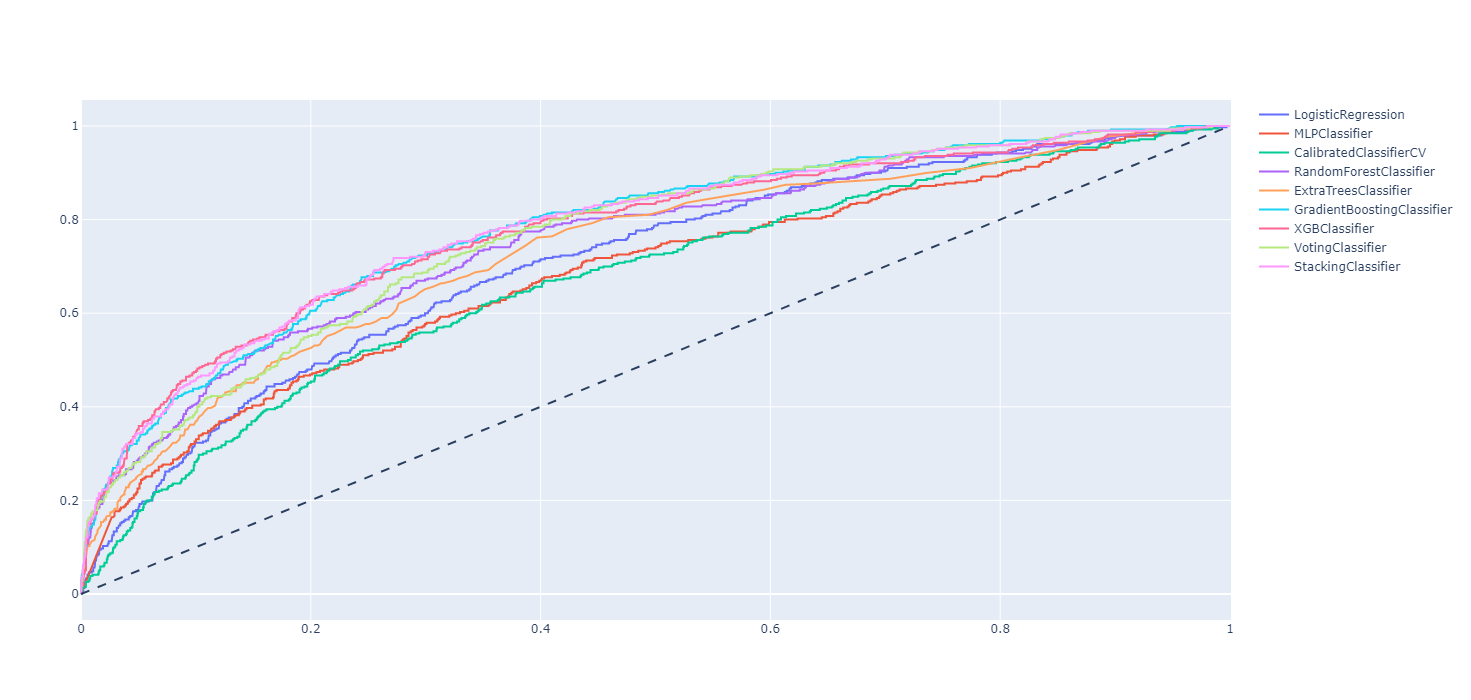

In [109]:
from sklearn.metrics import roc_curve, auc

fig = go.Figure()

fpr, tpr, thresholds = roc_curve(y_valid, lr_pred_prob[:,1])
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='LogisticRegression'))

fpr, tpr, thresholds = roc_curve(y_valid, mlp_pred_prob[:,1])
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='MLPClassifier'))

fpr, tpr, thresholds = roc_curve(y_valid, lsvc_pred_prob[:,1])
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='CalibratedClassifierCV'))

fpr, tpr, thresholds = roc_curve(y_valid, rf_pred_prob[:,1])
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='RandomForestClassifier'))

fpr, tpr, thresholds = roc_curve(y_valid, etree_pred_prob[:,1])
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ExtraTreesClassifier'))

fpr, tpr, thresholds = roc_curve(y_valid, gdboost_pred_prob[:,1])
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='GradientBoostingClassifier'))

fpr, tpr, thresholds = roc_curve(y_valid, xgb_pred_prob[:,1])
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='XGBClassifier'))

fpr, tpr, thresholds = roc_curve(y_valid, ensemble_vc_pred_prob[:,1])
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='VotingClassifier'))

fpr, tpr, thresholds = roc_curve(y_valid, ensemble_sc_pred_prob[:,1])
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='StackingClassifier'))
    
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_layout(width=800, height=700)

fig.show()

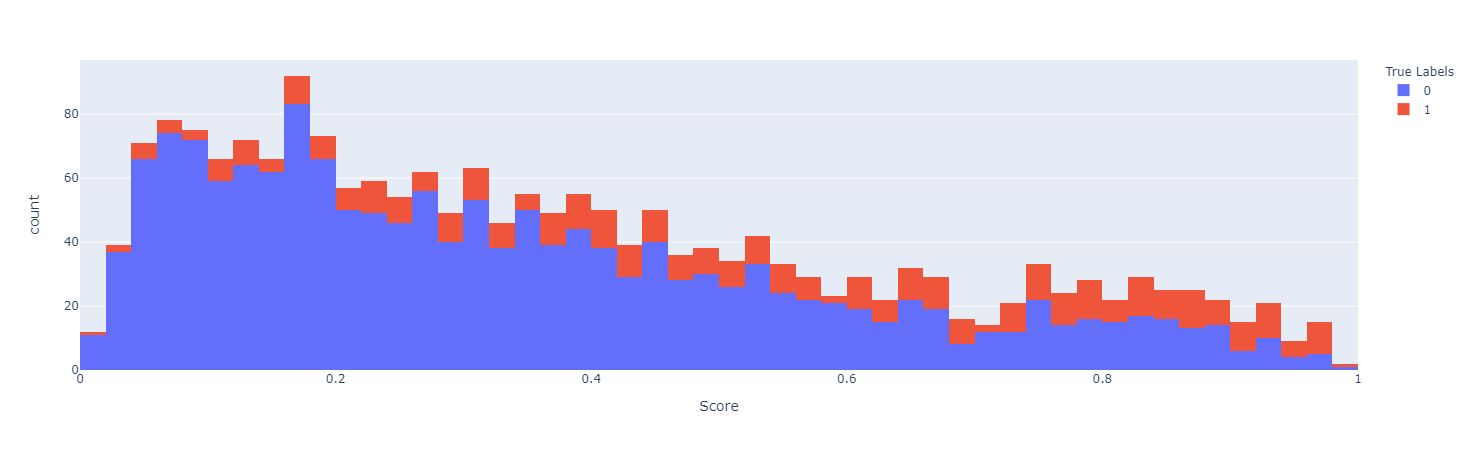

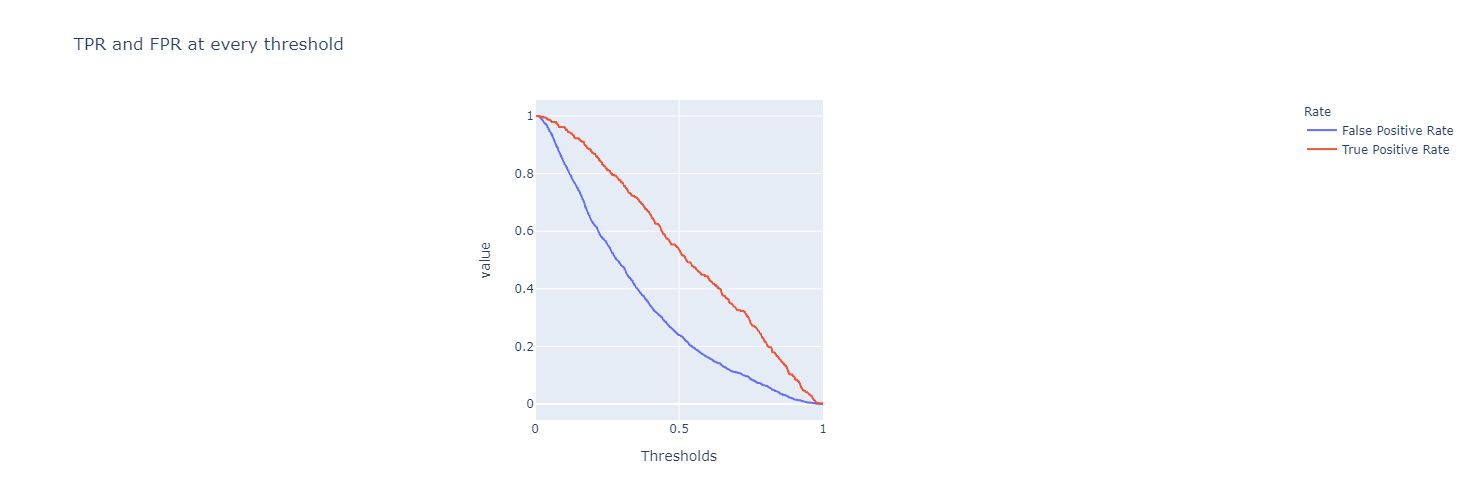

In [110]:
model_pred_prob = lr_pred_prob
fpr, tpr, thresholds = roc_curve(y_valid, model_pred_prob[:,1])

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=model_pred_prob[:,1], color=y_valid, nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

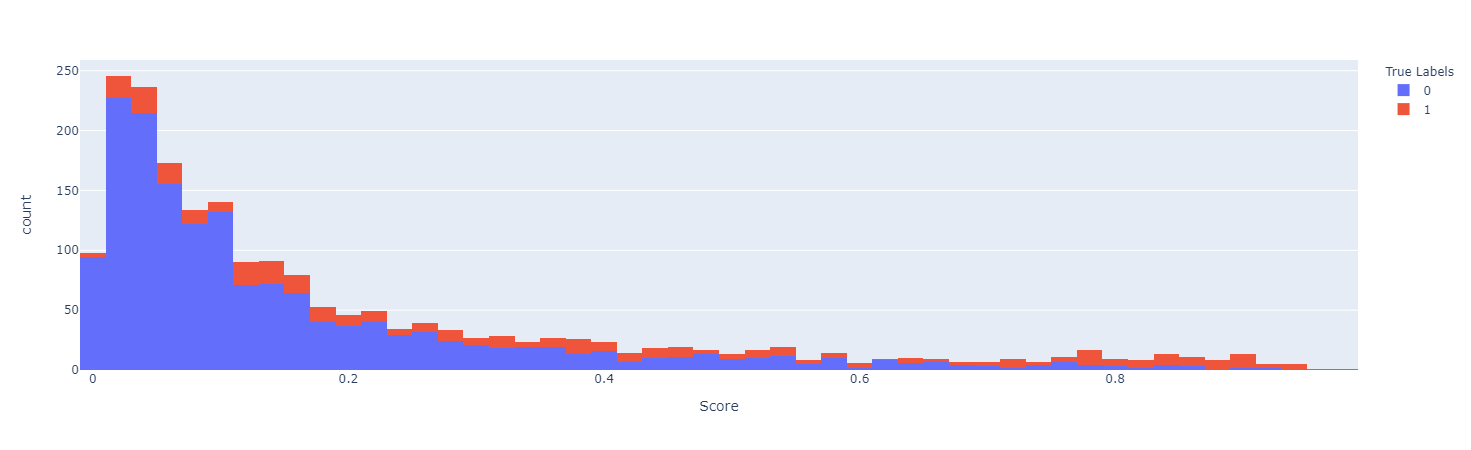

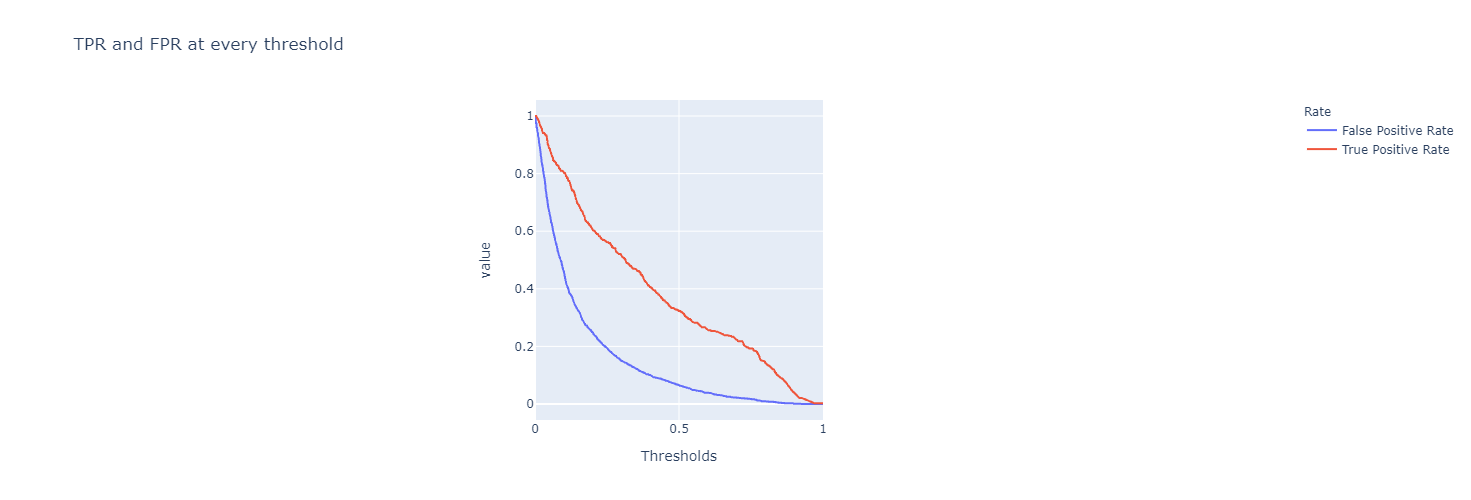

In [111]:
model_pred_prob = rf_pred_prob
# model_pred_prob = etree_pred_prob
fpr, tpr, thresholds = roc_curve(y_valid, model_pred_prob[:,1])

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=model_pred_prob[:,1], color=y_valid, nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

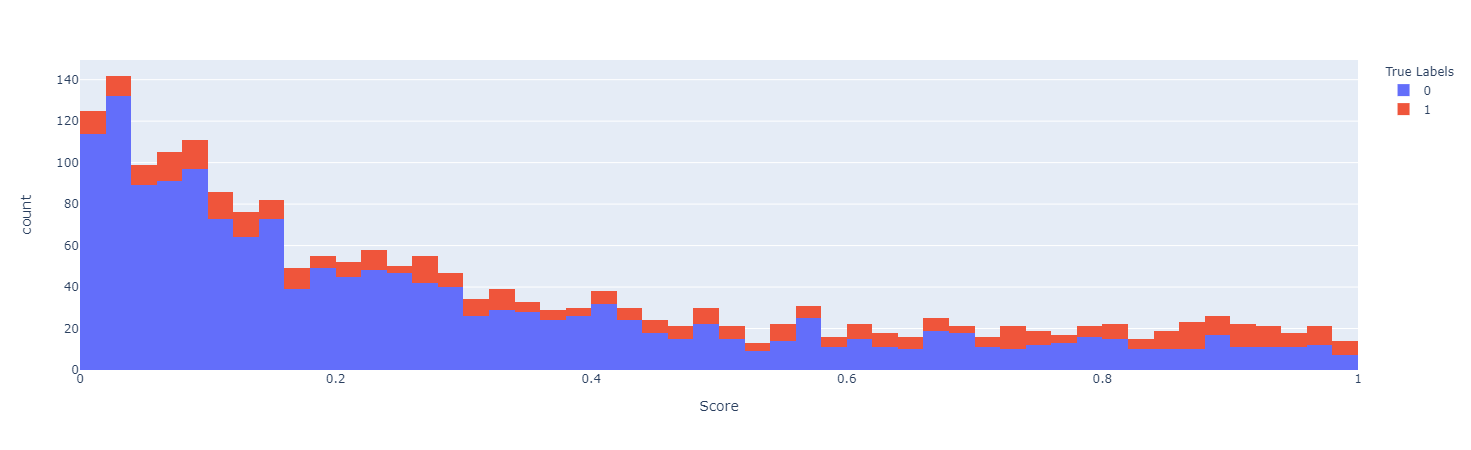

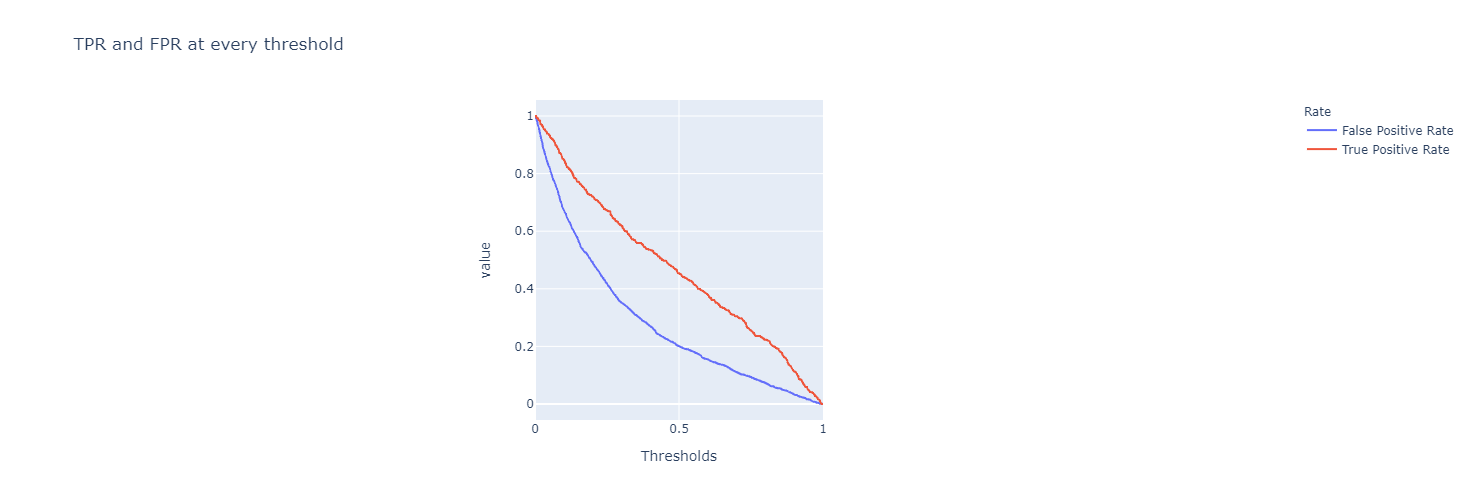

In [112]:
model_pred_prob = lsvc_pred_prob
fpr, tpr, thresholds = roc_curve(y_valid, model_pred_prob[:,1])

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=model_pred_prob[:,1], color=y_valid, nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

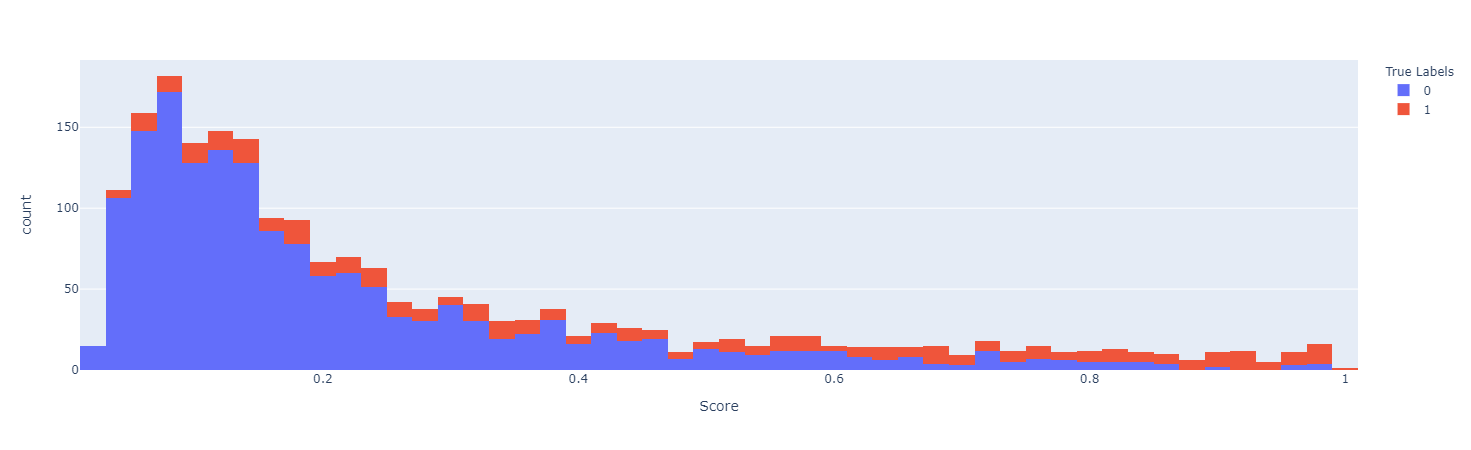

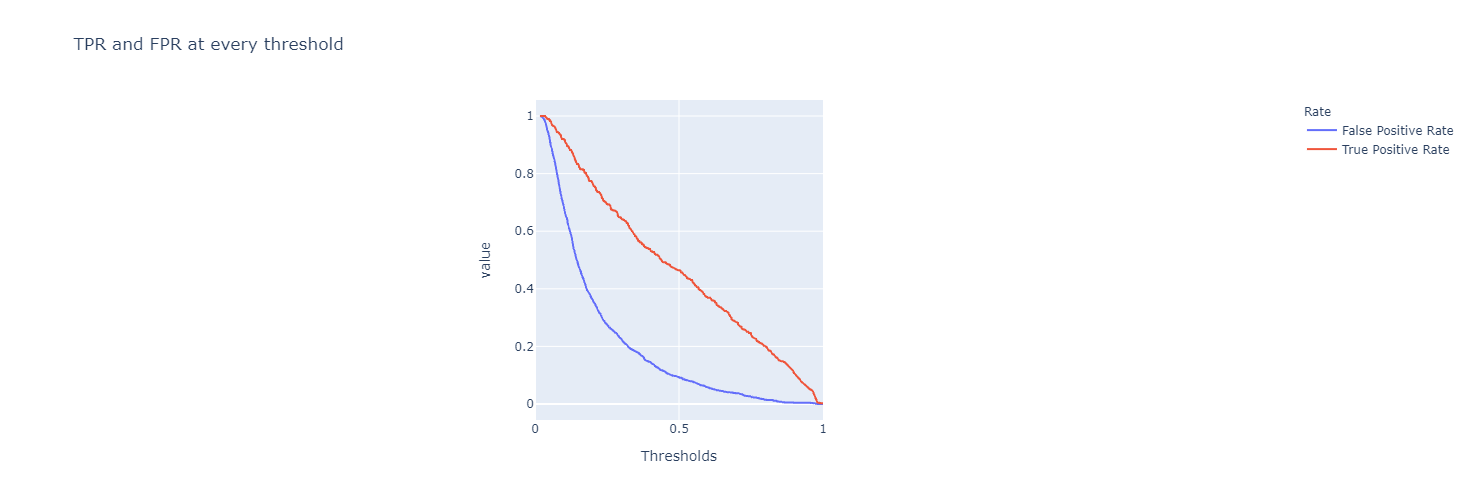

In [113]:
model_pred_prob = xgb_pred_prob
fpr, tpr, thresholds = roc_curve(y_valid, model_pred_prob[:,1])

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=model_pred_prob[:,1], color=y_valid, nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

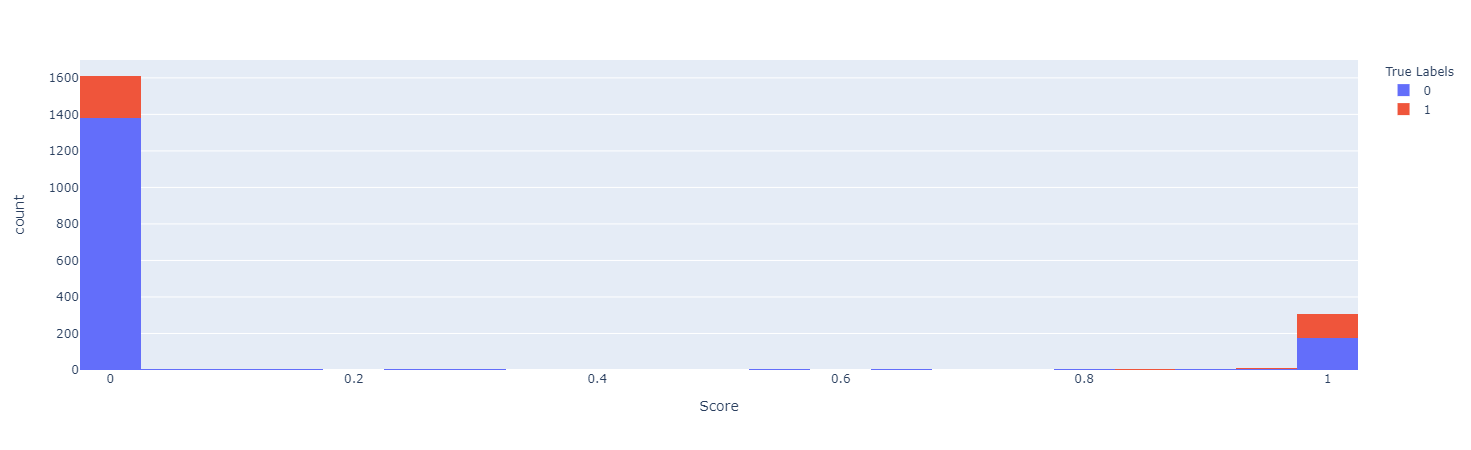

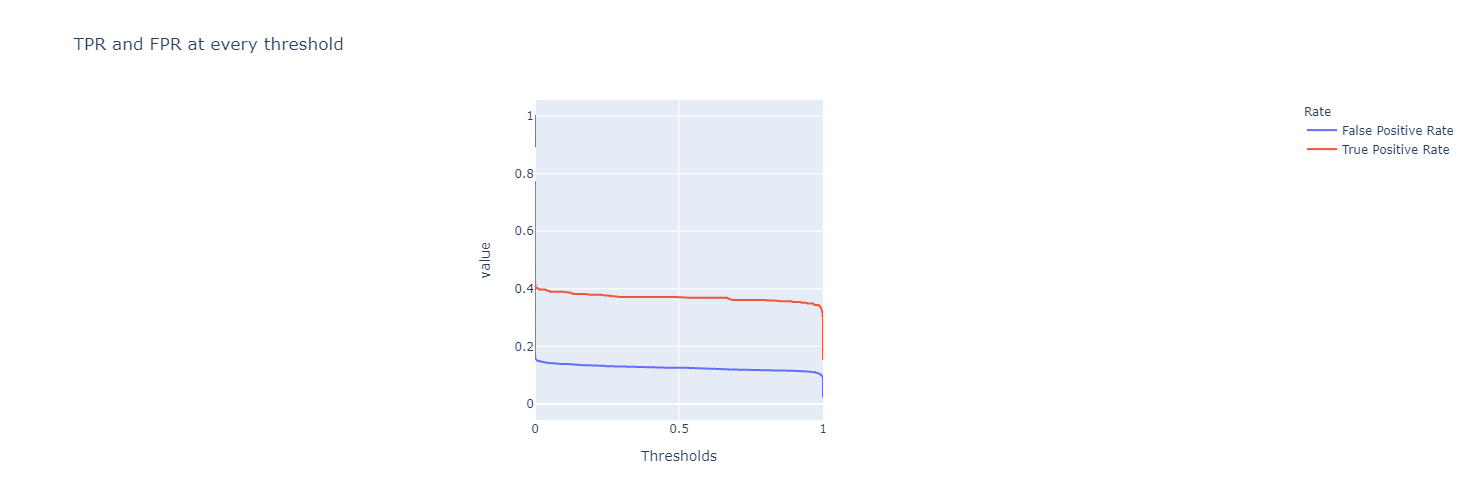

In [114]:
model_pred_prob = mlp_pred_prob
fpr, tpr, thresholds = roc_curve(y_valid, model_pred_prob[:,1])

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=model_pred_prob[:,1], color=y_valid, nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

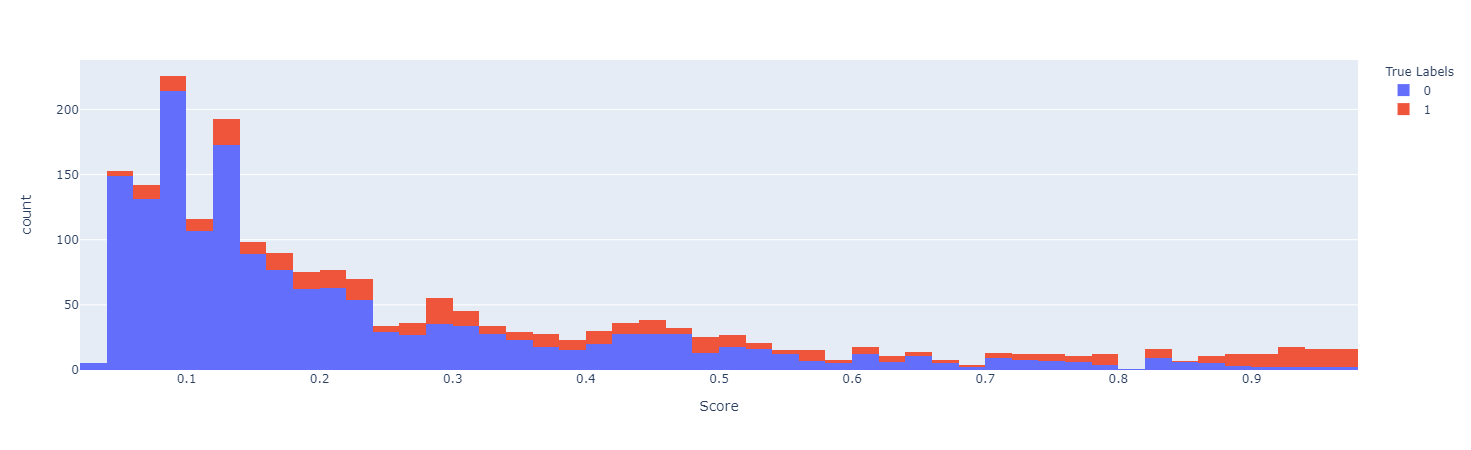

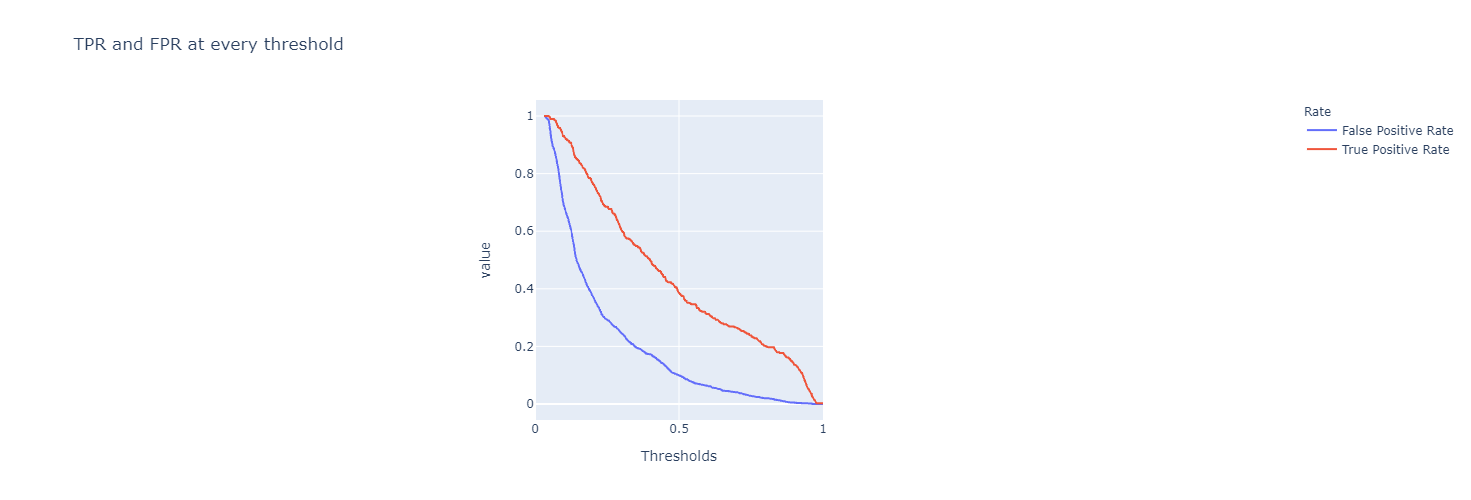

In [115]:
model_pred_prob = ensemble_vc_pred_prob
fpr, tpr, thresholds = roc_curve(y_valid, model_pred_prob[:,1])

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=model_pred_prob[:,1], color=y_valid, nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

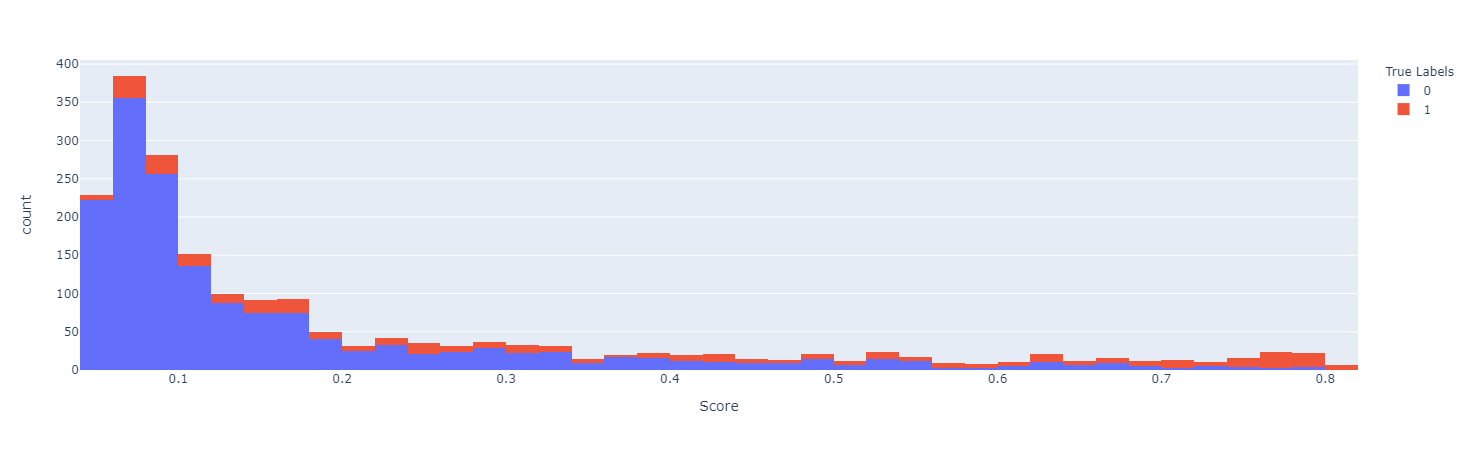

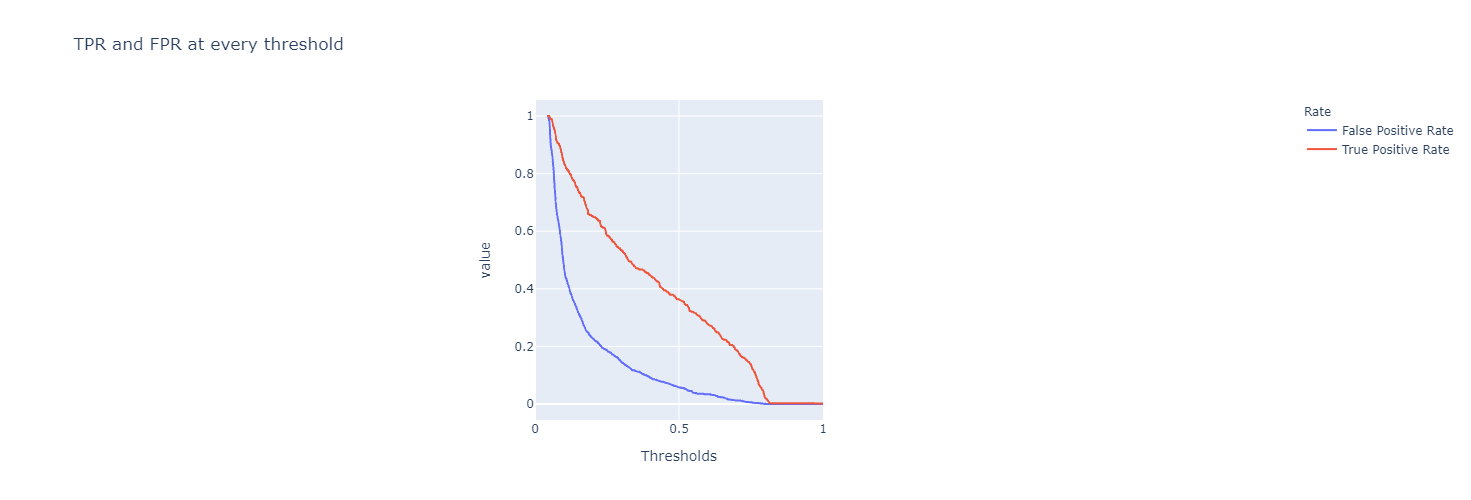

In [116]:
model_pred_prob = ensemble_sc_pred_prob
fpr, tpr, thresholds = roc_curve(y_valid, model_pred_prob[:,1])

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=model_pred_prob[:,1], color=y_valid, nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()